# Compatibility test 
## binnedFit/shift_cen with KLens/shift_cen
(Remember to checkout to the **shift_cen** branchs in both repo when running this notebook.)

In [1]:
import numpy as np
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as constants

import sys
import os

dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"

sys.path.append(dir_BinnedFit)
from gen_mocks import gen_mock_tfCube
from chainTool import ChainTool
from gamma import GammaInference

sys.path.append(dir_KLens)
from KLtool import plot_specs

from IPython.display import display as ipython_display
from binnedFit_utilities import velocity_to_lambda

### Generate tfCube mock 

In [2]:
###### set up parameters ######

line_species='Halpha'

pars = {}
pars['g1'] = 0.05
pars['g2'] = 0.05
pars['sini'] = 0.5

pars['redshift'] = 0.4

pars['aspect'] = 0.2
pars['r_hl_image'] = 0.5
pars['r_hl_spec'] = 0.5

pars['theta_int'] = 0. #np.pi/3.

pars['slitWidth'] = 0.06
pars['ngrid'] = 256

pars['dx_gal'] = 0.
pars['dy_gal'] = 0.

pars['norm'] = 0.0

pars['Resolution'] = 5000.
pars['expTime'] = 60.*30. #60.*30.
pars['pixScale'] = 0.1185
pars['nm_per_pixel'] = 0.033
pars['throughput'] = 0.29
pars['psfFWHM'] = 0.5

pars['area'] = 3.14 * (1000./2.)**2 

pars['vcirc'] = 200.

linelist = np.empty(5,dtype=[('species',np.str_,16),
                                  ('lambda',np.float64),
                                  ('flux',np.float64)])
linelist['species'] = ['OIIa','OIIb','OIIIa','OIIIb','Halpha']
linelist['lambda'] =  [372.7092,372.9875,496.0295,500.8240,656.461]

fiber_SDSS = np.pi * 1.5**2
refSDSSspec = 3.*1e-17 * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)

linelist['flux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]

pars['linelist'] = linelist

In [3]:
dataInfo = gen_mock_tfCube(pars, 'Halpha', slits='both', noise_mode=0)

### BinnedFit model at par_in = par_fid

In [4]:
# ----------------------
GI = GammaInference(dataInfo, active_par_key=[
    'vcirc', 'sini', 'vscale', 'r_0', 'v_0', 'g1', 'g2', 'r_hl_image', 'theta_int', 'flux'], 
                    par_fix=None, vTFR_mean=200.)

In [5]:
active_par_fid = [GI.par_fid[key] for key in GI.active_par_key]

print('par_fid')
for ind, key in enumerate(GI.active_par_key):
    print(f'  {key} : {active_par_fid[ind]:.2f}')

par_fid
  vcirc : 200.00
  sini : 0.50
  vscale : 0.50
  r_0 : 0.00
  v_0 : 0.00
  g1 : 0.05
  g2 : 0.05
  r_hl_image : 0.50
  theta_int : 0.00
  flux : 2067.55


In [6]:
active_par_in = active_par_fid

par_in = GI.Pars.gen_par_dict(active_par=active_par_in, active_par_key=GI.active_par_key, par_ref=GI.par_base)

print('par_in')
for ind, key in enumerate(GI.active_par_key):
    print(f'  {key} : {active_par_in[ind]:.2f}')

par_in
  vcirc : 200.00
  sini : 0.50
  vscale : 0.50
  r_0 : 0.00
  v_0 : 0.00
  g1 : 0.05
  g2 : 0.05
  r_hl_image : 0.50
  theta_int : 0.00
  flux : 2067.55


In [7]:
logPrior_vcirc = GI.Pars.logPrior_vcirc(vcirc=par_in['vcirc'], sigma_TF_intr=GI.sigma_TF_intr, vTFR_mean=GI.vTFR_mean)
logL_image, model_img = GI._cal_loglike_image(par_in)
logL_spec0, model_spec0 = GI._cal_loglike_spec(par_in, IDspec=0)
logL_spec1, model_spec1 = GI._cal_loglike_spec(par_in, IDspec=1)

totL = GI.cal_loglike(active_par_in)
print(f'tot logLike: {totL:.3f}')
print(f'  logPrior: {logPrior_vcirc:.3f}')
print(f'  logL_image: {logL_image:.3f}')
print(f'  logL_spec0: {logL_spec0:.3f}')
print(f'  logL_spec1: {logL_spec1:.3f}')

tot logLike: -8022.960
  logPrior: -0.000
  logL_image: -8018.893
  logL_spec0: -1.497
  logL_spec1: -2.570


### display - overplot

In [8]:
from IPython.display import display as ipython_display

dir_TNGcube = dir_repo+"/TNGcube"
sys.path.append(dir_TNGcube)

from TNGcube import Image
from spec2D import Spec2D

/Users/hhg/Research/kinematic_lensing/repo/BinnedFit/notebook/HH_notebook/../../../BinnedFit/../TNGcube/TNGcube.py:835: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 324x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faa68ec52d0>)

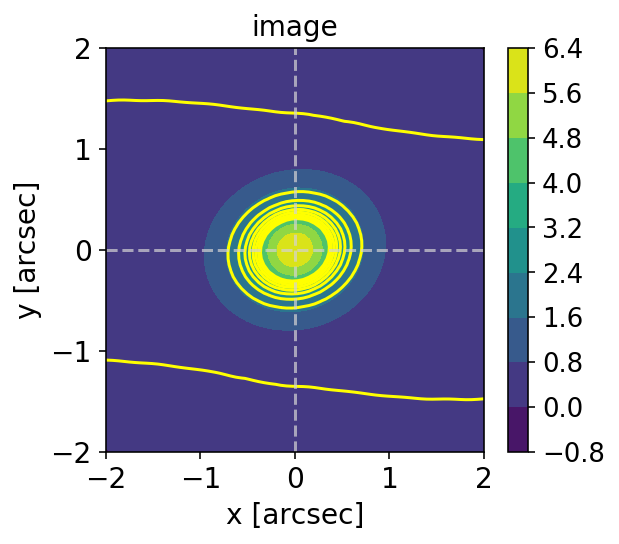

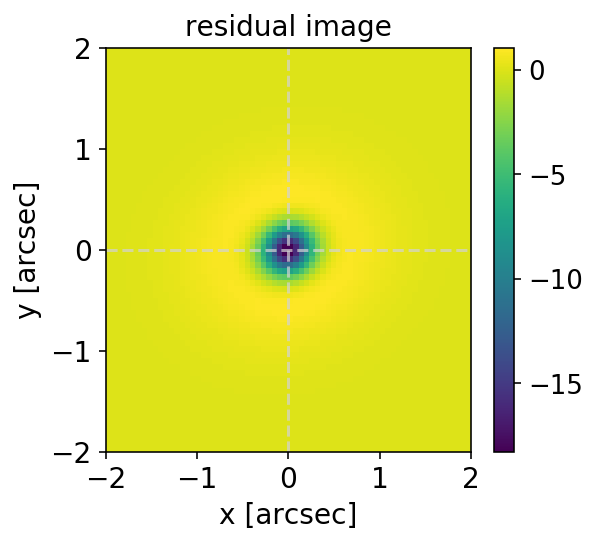

In [9]:
%matplotlib inline
fig0, ax0 = dataInfo['image'].display(xlim=[-2.,2.], model=model_img)

resImage = Image(dataInfo['image'].array-model_img, dataInfo['spaceGrid'], array_var=dataInfo['image_variance'])
resImage.display(xlim=[-2.,2.], title='residual image')

In [10]:
print('1sigma image: ', np.sqrt(dataInfo['image_variance']))

1sigma image:  0.737066883526326


# ------ Detailed Check ------

In [11]:
dataInfo['image'].array.shape

(256, 256)

In [12]:
model_img.shape

(256, 256)